# 基于XGBoost的短期汇率预测模型

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import date
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd
import numpy as np
import requests
from requests.auth import HTTPBasicAuth

from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


/Users/loki/PycharmProjects/PythonProject5/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 数据获取

- yfinance库

- 利率数据

In [2]:
# 获取人民币兑英镑汇率（Yahoo symbol: CNYGBP=X）
data = yf.download("CNYGBP=X", start="2015-01-01", end="2025-05-14")
er_df = data[["Close"]].rename(columns={"Close": "CNY/GBP"})
display(er_df.head())

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


Price,CNY/GBP
Ticker,CNYGBP=X
Date,
2015-01-01,0.10342
2015-01-02,0.10333
2015-01-05,0.10492
2015-01-06,0.10535
2015-01-07,0.10645


## 数据预处理

In [3]:
er_df['inverse'] = 1 / er_df['CNY/GBP', 'CNYGBP=X']
er_df.head()

Price,CNY/GBP,inverse
Ticker,CNYGBP=X,
Date,,
2015-01-01,0.10342,9.669310
2015-01-02,0.10333,9.677731
2015-01-05,0.10492,9.531071
2015-01-06,0.10535,9.492169
2015-01-07,0.10645,9.394082


In [4]:
policy_df = pd.read_excel("IR.xlsx")
policy_df['rate_diff'] = policy_df['UK'] - policy_df['CN']
model_df = policy_df.copy()

In [5]:
er_df['inverse']

Date
2015-01-01    9.669310
2015-01-02    9.677731
2015-01-05    9.531071
2015-01-06    9.492169
2015-01-07    9.394082
                ...   
2025-05-07    9.639391
2025-05-08    9.603934
2025-05-09    9.562058
2025-05-12    9.620287
2025-05-13    9.493972
Name: inverse, Length: 2699, dtype: float64

In [6]:
# 确保 Date 是 datetime 类型
model_df['Date'] = pd.to_datetime(model_df['Date'])

# 保留工作日（周一到周五）
df_weekday = model_df[model_df['Date'].dt.dayofweek < 5].copy()

# 按日期排序（可选）
df_weekday = df_weekday.sort_values('Date').reset_index(drop=True)

In [7]:
df_weekday

,Date,UK,CN,rate_diff
0,2015-01-01,0.50,5.6,-5.10
1,2015-01-02,0.50,5.6,-5.10
2,2015-01-05,0.50,5.6,-5.10
3,2015-01-06,0.50,5.6,-5.10
4,2015-01-07,0.50,5.6,-5.10
...,...,...,...,...
2699,2025-05-07,4.25,3.1,1.15
2700,2025-05-08,4.25,3.1,1.15
2701,2025-05-09,4.25,3.1,1.15
2702,2025-05-12,4.25,3.1,1.15


In [8]:
missing_dates = df_weekday[~df_weekday['Date'].isin(er_df.index)]
print(missing_dates['Date'].tail(10))


658    2017-07-11
750    2017-11-16
2609   2025-01-01
2686   2025-04-18
2687   2025-04-21
Name: Date, dtype: datetime64[ns]


In [9]:
# 确保 Date 列格式一致
df_weekday['Date'] = pd.to_datetime(df_weekday['Date']).dt.normalize()

# 筛选 df_weekday 中仅保留那些出现在 er_df['Date'] 中的行
df_weekday_aligned = df_weekday[df_weekday['Date'].isin(er_df.index)].copy()

# 重置索引（可选）
df_weekday_aligned = df_weekday_aligned.reset_index(drop=True)

In [10]:
er_mid = er_df['inverse'].reset_index(drop=True)


In [11]:
df_weekday_aligned['ER'] = er_mid
df_weekday_aligned

,Date,UK,CN,rate_diff,ER
0,2015-01-01,0.50,5.6,-5.10,9.669310
1,2015-01-02,0.50,5.6,-5.10,9.677731
2,2015-01-05,0.50,5.6,-5.10,9.531071
3,2015-01-06,0.50,5.6,-5.10,9.492169
4,2015-01-07,0.50,5.6,-5.10,9.394082
...,...,...,...,...,...
2694,2025-05-07,4.25,3.1,1.15,9.639391
2695,2025-05-08,4.25,3.1,1.15,9.603934
2696,2025-05-09,4.25,3.1,1.15,9.562058
2697,2025-05-12,4.25,3.1,1.15,9.620287


## 模型构建

In [12]:
def recalculate_features(df):
    df = df.copy()

    # 滞后收益率
    df['return_1'] = df['ER'].pct_change()
    df['SMA_5'] = df['ER'].rolling(window=5).mean()
    df['SMA_10'] = df['ER'].rolling(window=10).mean()
    df['Momentum_5'] = df['ER'] - df['ER'].shift(5)
    df['Volatility_5'] = df['return_1'].rolling(window=5).std()

    df['SMA_diff'] = df['SMA_5'] - df['SMA_10']
    df['price_SMA5_ratio'] = df['ER'] / df['SMA_5']
    df['price_minus_SMA5'] = df['ER'] - df['SMA_5']

    df['return_2'] = df['ER'].pct_change(2)
    df['return_3'] = df['ER'].pct_change(3)

    df['rolling_std_10'] = df['ER'].rolling(window=10).std()

    df['vol_mom'] = df['Volatility_5'] * df['Momentum_5']
    df['price_return_interact'] = df['price_minus_SMA5'] * df['return_1']

    df['shock'] = (df['ER'].pct_change().abs() > 0.2).astype(int)

    df['trade_war'] = 0
    df.loc[(df['Date'] >= '2018-07-01') & (df['Date'] <= '2019-12-31'), 'trade_war'] = 1
    df.loc[(df['Date'] >= '2025-04-02'), 'trade_war'] = 1

    df['rolling_return'] = df['ER'].pct_change().rolling(3).sum()
    df['shock_flag'] = (df['rolling_return'].abs() > 0.03).astype(int)

    df['trend_5'] = df['ER'].rolling(window=5).apply(lambda x: np.polyfit(range(5), x, 1)[0], raw=True)

    df.index = pd.to_datetime(df.index)

    df['dayofweek'] = df.index.dayofweek
    df['is_month_end'] = df.index.is_month_end.astype(int)

    df['volatility_10'] = df['ER'].pct_change().rolling(window=10).std()
    df['vol_spike'] = (df['volatility_10'] > df['volatility_10'].rolling(100).mean() + 2 * df['volatility_10'].rolling(100).std()).astype(int)


    # RSI
    delta = df['ER'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    return df


In [13]:
df = df_weekday_aligned.copy()

# 构造技术指标特征
df['return_1'] = df['ER'].pct_change()
df['SMA_5'] = df['ER'].rolling(window=5).mean()
df['SMA_10'] = df['ER'].rolling(window=10).mean()
df['Momentum_5'] = df['ER'] - df['ER'].shift(5)
df['Volatility_5'] = df['return_1'].rolling(window=5).std()

df['SMA_diff'] = df['SMA_5'] - df['SMA_10']
df['price_SMA5_ratio'] = df['ER'] / df['SMA_5']
df['price_minus_SMA5'] = df['ER'] - df['SMA_5']

df['return_2'] = df['ER'].pct_change(2)
df['return_3'] = df['ER'].pct_change(3)

df['rolling_std_10'] = df['ER'].rolling(window=10).std()

df['vol_mom'] = df['Volatility_5'] * df['Momentum_5']
df['price_return_interact'] = df['price_minus_SMA5'] * df['return_1']

df['shock'] = (df['ER'].pct_change().abs() > 0.2).astype(int)

df['trade_war'] = 0
df.loc[(df['Date'] >= '2018-07-01') & (df['Date'] <= '2019-12-31'), 'trade_war'] = 1
df.loc[(df['Date'] >= '2025-04-02'), 'trade_war'] = 1

df['rolling_return'] = df['ER'].pct_change().rolling(3).sum()
df['shock_flag'] = (df['rolling_return'].abs() > 0.03).astype(int)

df['trend_5'] = df['ER'].rolling(window=5).apply(lambda x: np.polyfit(range(5), x, 1)[0], raw=True)

df.index = pd.to_datetime(df.index)

df['dayofweek'] = df.index.dayofweek
df['is_month_end'] = df.index.is_month_end.astype(int)

df['volatility_10'] = df['ER'].pct_change().rolling(window=10).std()
df['vol_spike'] = (df['volatility_10'] > df['volatility_10'].rolling(100).mean() + 2 * df['volatility_10'].rolling(100).std()).astype(int)





In [14]:
# RSI
delta = df['ER'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))


In [15]:
from arch import arch_model

returns = df['ER'].pct_change().dropna() * 100
model = arch_model(returns, vol='GARCH', p=1, q=1)
res = model.fit(disp='off')
df['garch_vol'] = res.conditional_volatility


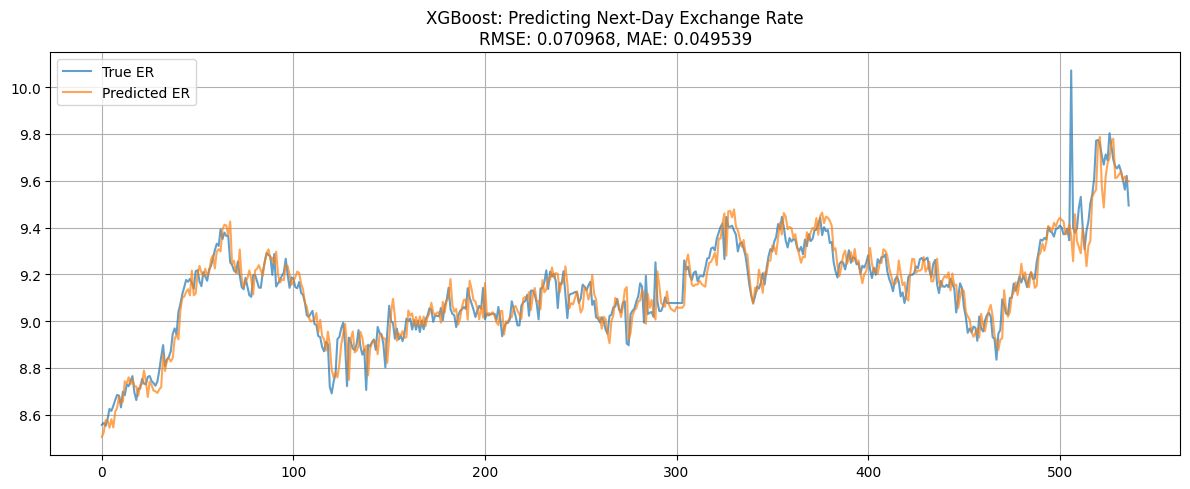

In [16]:
# 构造目标变量：下一期 ER
df['target'] = df['ER'].shift(-1)

df_model = df.dropna()

features = ['shock_flag','vol_mom','rolling_std_10','return_3','return_2','return_1','price_minus_SMA5','price_SMA5_ratio','SMA_5', 'SMA_10', 'Momentum_5', 'rate_diff','Volatility_5','RSI_14','SMA_diff','price_return_interact','trade_war','dayofweek','is_month_end','garch_vol','vol_spike','trend_5']
X = df_model[features]
y = df_model['target']

# 时间顺序分割数据
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 构建模型
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# 可视化
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='True ER', alpha=0.7)
plt.plot(y_pred, label='Predicted ER', alpha=0.7)
plt.title(f'XGBoost: Predicting Next-Day Exchange Rate\nRMSE: {rmse:.6f}, MAE: {mae:.6f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


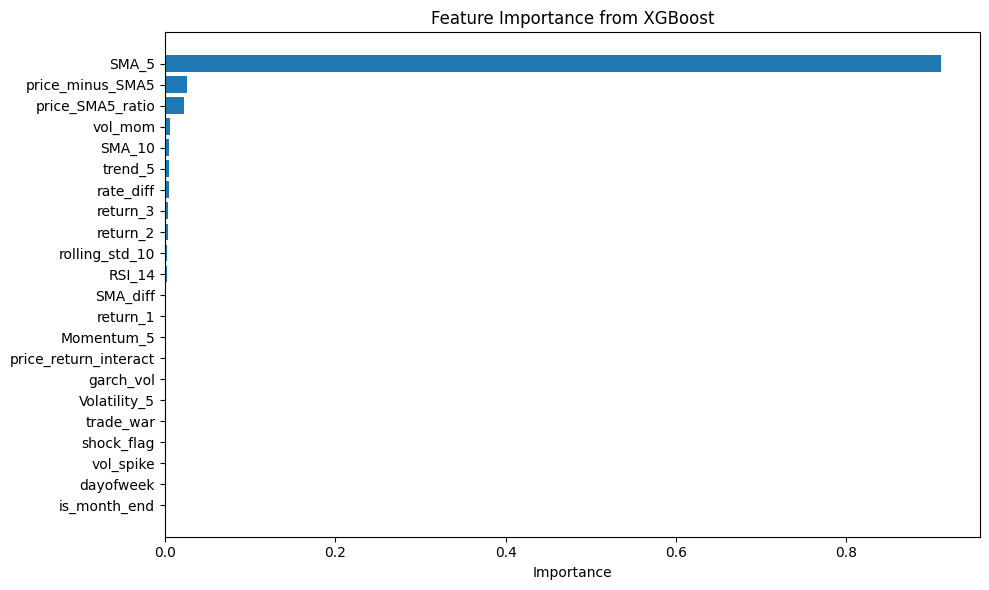

In [17]:
# 获取特征重要性
importances = model.feature_importances_
features = X_test.columns

# 转为DataFrame，便于排序和可视化
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 可视化
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # 重要性高的放在上面
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [18]:
pred_df = pd.DataFrame(y_pred)
y_test = y_test.iloc[:-1]
error_cal = pd.DataFrame({})
error_cal['pred'] = pred_df
y_mid = y_test.reset_index(drop=True)
error_cal['actual'] = y_mid
error_cal['error'] = error_cal['pred'] - error_cal['actual']

In [19]:
# 计算实际值和预测值的变化趋势（相邻天数差）
actual_diff = error_cal['actual'].diff()
pred_diff = error_cal['pred'].diff()

# 判断趋势是否一致（同为正或同为负 → 相乘大于0）
trend_correct = (actual_diff * pred_diff) > 0

# 去除第一个 NaN（因为 diff 会在第一行生成 NaN）
trend_correct = trend_correct[1:-1]

# 计算正确比例
trend_accuracy = trend_correct.sum() / len(trend_correct)

# 输出
print(f"📈 趋势判断正确的比例为: {trend_accuracy:.2%}")

📈 趋势判断正确的比例为: 46.36%


In [20]:
threshold = 0.05
proportion = (error_cal['error'].abs() > threshold).mean()

print(f"误差大于 0.05 的比例为：{proportion:.2%}")

误差大于 0.05 的比例为：36.31%


## Prediction Application

In [21]:
today = date.today()

In [22]:
# 获取人民币兑英镑汇率（Yahoo symbol: CNYGBP=X）
data = yf.download("CNYGBP=X", start="2015-01-01", end=today)
er_df = data[["Close"]].rename(columns={"Close": "CNY/GBP"})
display(er_df)

[*********************100%***********************]  1 of 1 completed


Price,CNY/GBP
Ticker,CNYGBP=X
Date,
2015-01-01,0.103420
2015-01-02,0.103330
2015-01-05,0.104920
2015-01-06,0.105350
2015-01-07,0.106450
...,...
2025-05-19,0.104254
2025-05-20,0.103815


In [23]:
er_df['inverse'] = 1 / er_df['CNY/GBP', 'CNYGBP=X']
er_df

Price,CNY/GBP,inverse
Ticker,CNYGBP=X,
Date,,
2015-01-01,0.103420,9.669310
2015-01-02,0.103330,9.677731
2015-01-05,0.104920,9.531071
2015-01-06,0.105350,9.492169
2015-01-07,0.106450,9.394082
...,...,...
2025-05-19,0.104254,9.591958
2025-05-20,0.103815,9.632520


In [24]:
policy_df = pd.read_excel("IR.xlsx")
policy_df['rate_diff'] = policy_df['UK'] - policy_df['CN']

model_df = policy_df.copy()

In [25]:
# 确保 Date 是 datetime 类型
model_df['Date'] = pd.to_datetime(model_df['Date'])

# 保留工作日（周一到周五）
df_weekday = model_df[model_df['Date'].dt.dayofweek < 5].copy()

# 按日期排序（可选）
df_weekday = df_weekday.sort_values('Date').reset_index(drop=True)

In [26]:
missing_dates = df_weekday[~df_weekday['Date'].isin(er_df.index)]
display(missing_dates['Date'].tail(10))

# 确保 Date 列格式一致
df_weekday['Date'] = pd.to_datetime(df_weekday['Date']).dt.normalize()

# 筛选 df_weekday 中仅保留那些出现在 er_df['Date'] 中的行
df_weekday_aligned = df_weekday[df_weekday['Date'].isin(er_df.index)].copy()

# 重置索引（可选）
df_weekday_aligned = df_weekday_aligned.reset_index(drop=True)

df_weekday_aligned

658    2017-07-11
750    2017-11-16
2609   2025-01-01
2686   2025-04-18
2687   2025-04-21
Name: Date, dtype: datetime64[ns]

,Date,UK,CN,rate_diff
0,2015-01-01,0.50,5.6,-5.10
1,2015-01-02,0.50,5.6,-5.10
2,2015-01-05,0.50,5.6,-5.10
3,2015-01-06,0.50,5.6,-5.10
4,2015-01-07,0.50,5.6,-5.10
...,...,...,...,...
2694,2025-05-07,4.25,3.1,1.15
2695,2025-05-08,4.25,3.1,1.15
2696,2025-05-09,4.25,3.1,1.15
2697,2025-05-12,4.25,3.1,1.15


In [27]:
while len(df_weekday_aligned['Date']) < len(er_df.index):
    df_weekday_aligned.loc[len(df_weekday_aligned['Date'])] = [er_df.index[len(df_weekday_aligned)], 4.25,3.1,1.15]

In [28]:
er_mid = er_df['inverse'].reset_index(drop=True)

df_weekday_aligned['ER'] = er_mid
df_weekday_aligned

,Date,UK,CN,rate_diff,ER
0,2015-01-01,0.50,5.6,-5.10,9.669310
1,2015-01-02,0.50,5.6,-5.10,9.677731
2,2015-01-05,0.50,5.6,-5.10,9.531071
3,2015-01-06,0.50,5.6,-5.10,9.492169
4,2015-01-07,0.50,5.6,-5.10,9.394082
...,...,...,...,...,...
2702,2025-05-19,4.25,3.1,1.15,9.591958
2703,2025-05-20,4.25,3.1,1.15,9.632520
2704,2025-05-21,4.25,3.1,1.15,9.673144
2705,2025-05-22,4.25,3.1,1.15,9.666599


In [29]:
def recalculate_features(df):
    df = df.copy()

    # 滞后收益率
    df['return_1'] = df['ER'].pct_change()
    df['SMA_5'] = df['ER'].rolling(window=5).mean()
    df['SMA_10'] = df['ER'].rolling(window=10).mean()
    df['Momentum_5'] = df['ER'] - df['ER'].shift(5)
    df['Volatility_5'] = df['return_1'].rolling(window=5).std()

    df['SMA_diff'] = df['SMA_5'] - df['SMA_10']
    df['price_SMA5_ratio'] = df['ER'] / df['SMA_5']
    df['price_minus_SMA5'] = df['ER'] - df['SMA_5']

    df['return_2'] = df['ER'].pct_change(2)
    df['return_3'] = df['ER'].pct_change(3)

    df['rolling_std_10'] = df['ER'].rolling(window=10).std()

    df['vol_mom'] = df['Volatility_5'] * df['Momentum_5']
    df['price_return_interact'] = df['price_minus_SMA5'] * df['return_1']

    df['shock'] = (df['ER'].pct_change().abs() > 0.2).astype(int)

    df['trade_war'] = 0
    df.loc[(df['Date'] >= '2018-07-01') & (df['Date'] <= '2019-12-31'), 'trade_war'] = 1
    df.loc[(df['Date'] >= '2025-04-02'), 'trade_war'] = 1

    df['rolling_return'] = df['ER'].pct_change().rolling(3).sum()
    df['shock_flag'] = (df['rolling_return'].abs() > 0.03).astype(int)

    # RSI
    delta = df['ER'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    return df


In [30]:
latest_features = df[model.feature_names_in_].iloc[-1].values.reshape(1, -1)

predicted_tomorrow = model.predict(latest_features)[0]
print(f"✅ 明天的预测汇率是：{predicted_tomorrow:.4f}")

✅ 明天的预测汇率是：9.5063


In [31]:
def predict_next_n_days(df, model, n_days=7):
    df_extended = df.copy()
    predictions = []
    df_extended.index = pd.to_datetime(df_extended.index, errors='coerce')
    for i in range(n_days):
        # 获取最新一行数据作为输入
        latest_features = df_extended[model.feature_names_in_].iloc[-1].values.reshape(1, -1)
        pred = model.predict(latest_features)[0]
        df_extended.index = pd.to_datetime(df_extended.index)
        # 保存预测结果
        predictions.append(pred)
        # 构造下一行数据：复制最后一行，并替换汇率为预测值
        next_day = df_extended.index[-1] + pd.Timedelta(days=1)
        new_row = df_extended.iloc[-1].copy()
        new_row['ER'] = pred
        df_extended.loc[next_day] = new_row  # 自动续上
        df_extended = recalculate_features(df_extended)

    return predictions


In [32]:
pred = predict_next_n_days(df, model, n_days=7)
pred

[np.float32(9.506288),
 np.float32(9.487847),
 np.float32(9.453669),
 np.float32(9.397203),
 np.float32(9.447822),
 np.float32(9.435051),
 np.float32(9.42793)]

In [33]:
df_pred = er_df['inverse'].copy()
last_date = df_pred.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(pred))

for i in range(len(pred)):
    df_pred.loc[future_dates[i]] = pred[i]
df_pred

Date
2015-01-01    9.669310
2015-01-02    9.677731
2015-01-05    9.531071
2015-01-06    9.492169
2015-01-07    9.394082
                ...   
2025-05-26    9.453669
2025-05-27    9.397203
2025-05-28    9.447822
2025-05-29    9.435051
2025-05-30    9.427930
Name: inverse, Length: 2714, dtype: float64

In [34]:
def plot_prediction(df_pred, forecast_days=7):
    df_pred = df_pred.copy()
    df_pred.index = pd.to_datetime(df_pred.index)

    # 整段画完整的蓝线
    display_range = df_pred.iloc[-(forecast_days + 30):]

    plt.figure(figsize=(10, 5))
    plt.plot(display_range.index, display_range.values, label='Historical + Forecast', color='blue', linewidth=2)

    # 再覆盖预测部分（换颜色、虚线）
    forecast = df_pred.iloc[-forecast_days:]
    plt.plot(forecast.index, forecast.values, label='Forecast (Next 7 days)', color='orange', linestyle='--', marker='o')

    plt.title('CNY/GBP Exchange Rate: Last 30 Days + 7-Day Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

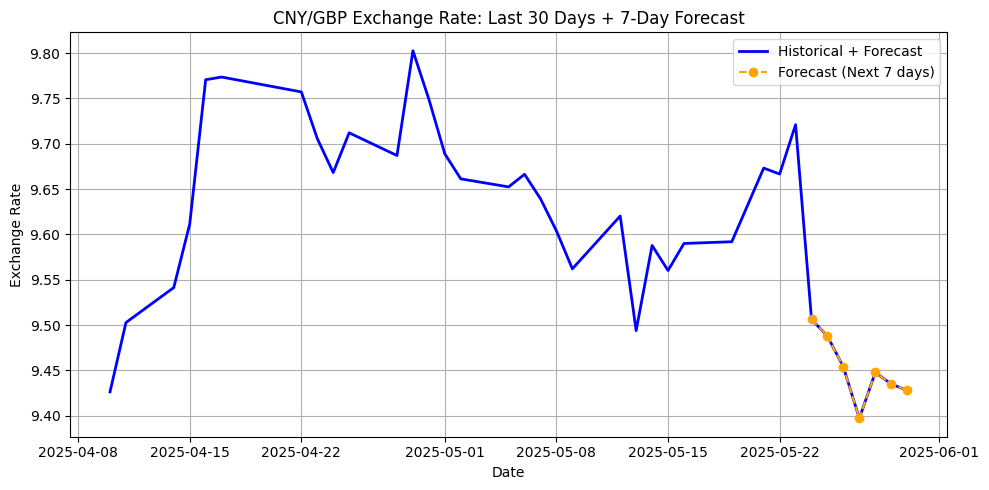

In [35]:
plot_prediction(df_pred, forecast_days=7)